In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
%run setup_notebook.py

In [5]:
from src.inference import compute_logdet
from src.utils import compute_logdet_bounds

# Preconditionner


With 

* $A = Q \Lambda Q^\top$
* $\hat A = A + \sigma^2 I$

Compute the rank-$k$ partial pivoted Cholesky $P_k = L_k L_k^\top \approx A$, then set the preconditionner $\hat P_k = P_k + \sigma^2 I$.

We want to compare $\kappa(\hat A)$ against $\kappa\left( \hat P_k^{-1/2} \hat A \hat P_k^{-1/2} \right)$.

In [293]:
from src.precond import PartialCholesky

In [312]:
n = 100
sigma2 = 0.1

eigs = torch.logspace(-1, 5, n)
Q = torch.from_numpy(ortho_group.rvs(n))
A = Q @ torch.diag(eigs) @ Q.T
Ahat = A + torch.eye(n) * sigma2

condAhat = torch.linalg.cond(Ahat)

eigs_unif = torch.linspace(eigs.min(), eigs.max(), n)
A_unif = Q @ torch.diag(eigs_unif) @ Q.T
Ahat_unif = A_unif + torch.eye(n) * sigma2

condAhat_unif = torch.linalg.cond(Ahat_unif)

# They obviously have the same condition number
condAhat, condAhat_unif

(tensor(500000.5000), tensor(500000.5000))

In [313]:
def compute_precond_eigs(A, k, sigma2):
    P = PartialCholesky(A, k, sigma2)
    Ahat = A + torch.eye(n) * sigma2
    precond_mx = P.inv_fun(Ahat)
    precond_eigs = torch.real(torch.linalg.eigvals(precond_mx))
    return precond_eigs

In [314]:
ks = np.linspace(1, 100, 10, dtype=int)
condition_nums = []
condition_nums_unif = []

for k in ks:
    precond_eigs = compute_precond_eigs(A, k, sigma2)
    
    cond_precond = precond_eigs.max() / precond_eigs.min()
    #print(precond_eigs.min())
    condition_nums.append(cond_precond)
    
    precond_eigs = compute_precond_eigs(A_unif, k, sigma2)
    condition_nums_unif.append(precond_eigs.max() / precond_eigs.min())

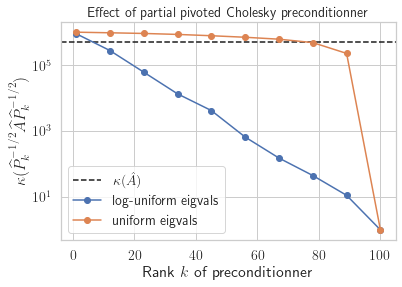

In [315]:
plt.axhline(y=condAhat, color='k', ls='--', label='$\kappa(\hat A)$')
plt.semilogy(ks, condition_nums, '-o', label='log-uniform eigvals')
plt.semilogy(ks, condition_nums_unif, '-o', label='uniform eigvals')

plt.xlabel('Rank $k$ of preconditionner')
plt.ylabel('$\kappa(\widehat P_k^{-1/2} \widehat A \widehat P_k^{-1/2})$')
plt.title('Effect of partial pivoted Cholesky preconditionner')
plt.legend();

Problem: when increasing matrix size $n$, then $m$ must be big so that $\kappa(\hat P^{-1} \hat K)$ is even lower than $\kappa(\hat K)$

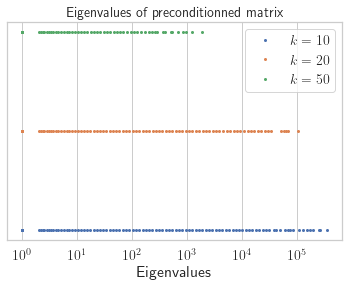

In [316]:
for i, k in enumerate([10, 20, 50]):
    precond_eigs = compute_precond_eigs(A, k, sigma2)
    plt.semilogx(precond_eigs, torch.ones(n) * i, 'o', label=f'$k={k}$', markersize=2)

plt.yticks([])
plt.xlabel('Eigenvalues')
plt.title('Eigenvalues of preconditionned matrix')
plt.legend();

# Error Lanczos quadrature

The error upperbound is (see Cortinovis paper):
$$
|\mathbf x^\top \log(A) \mathbf x - \Vert \mathbf x \Vert_2^2 \mathbf e_1^\top log(T_m) \mathbf e_1 |
\le c_a \Vert \mathbf x \Vert_2^2 \left( \frac{\sqrt{\kappa(A) + 1} - 1}{\sqrt{\kappa(A) + 1} + 1} \right) ^{2m},
\quad c_A := 2 ( \sqrt{\kappa(A) + 1} + 1) \log(2\kappa(A))
$$

Aim: for a SPD matrix $A$ with known eigenvalues, compute some big number of Lanczos steps $M$ and visualize the error for different numbers $m$. The $T_m$ matrix can be extracted from the big $T_M$ matrix. 

In [317]:
from src.quadrature import lanczos_quadrature
from src.cg import mbcg
from src.chol import pivoted_chol

First generate the matrix $A = Q \Lambda Q^\top$ with eigenvalues evenly distributed logarithmically in $[1, 10^4]$

In [352]:
n = 500
sigma2 = 1.0
eigs = torch.logspace(0, 4, n)
#eigs = torch.linspace(1, 1e4, n)
Q = torch.from_numpy(ortho_group.rvs(n))
A = Q @ torch.diag(eigs) @ Q.T

Run the mBCG algorithm with $M = n$ steps:

In [353]:
M = 500
# Probe vector
x = torch.randn(n)
x0 = torch.zeros(n)

sol, (T,) = mbcg(lambda X: A@X, lambda X: X, x, x0, M)
trueval = (x.T @ Q) @ torch.diag(eigs.log()) @ (Q.T @ x)

Compute the $m$-step Lanczos quadratures from the matrix $T \in \mathbb R^{M \times M}$, with $T_m = T_{1:m, 1:m}$

In [354]:
ms = np.linspace(10, M, 10, dtype=int)
quadrature_estimates = [
    lanczos_quadrature(f=torch.log, Tm=T[:m, :m], z=x, matrix_size=n)
    for m in ms
]

Compute the convergence rate:

In [355]:
def compute_convergence_rate(eigs):
    condA = eigs.max() / eigs.min()
    factor_cond = (condA + 1) ** 0.5
    #cA = 2 * (factor_cond + 1) * np.log(2*condA)
    convergence_rate = (factor_cond - 1) / (factor_cond + 1)
    return convergence_rate**2
    #return x.dot(x) * cA * convergence_rate**(2*ms)

In [356]:
convergence_rate = compute_convergence_rate(eigs)
convergence_rate

tensor(0.9608)

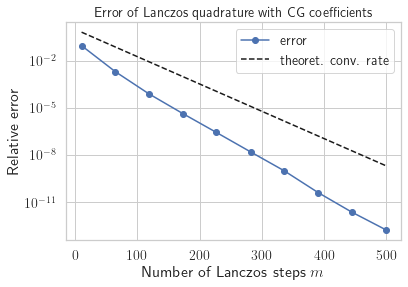

In [357]:
errs = (trueval - torch.tensor(quadrature_estimates)).abs() / trueval
#bound = compute_quadrature_upperbound(eigs, ms, x)
plt.semilogy(ms, errs, '-o', label='error')
plt.semilogy(ms, convergence_rate**ms, '--k', label='theoret. conv. rate')
plt.xlabel('Number of Lanczos steps $m$')
plt.ylabel('Relative error')
plt.title('Error of Lanczos quadrature with CG coefficients')
plt.legend();

Question: why works better if linspace eigvals? => if logspace, more clustered, Lanczos works best with well separated eigvals?

# Bounds on $N$, $m$

In [5]:
from math import log10

def build_A(n: int, lmin: float, lmax: float, device='cuda'):
    assert lmin > 0
    
    Q = torch.from_numpy(ortho_group.rvs(n)).to(device)
    eigs = torch.logspace(log10(lmin), log10(lmax), n, device=device)
    A = Q @ torch.diag(eigs) @ Q.T
    
    return A, eigs

In [6]:
A, eigs = build_A(1000, 1, 10000)

In [19]:
# True logdet
eigs.log().sum(), torch.logdet(A)

(tensor(4605.1702, device='cuda:0'), tensor(4605.1702, device='cuda:0'))

In [7]:
relerr = 0.05
proba_error = 0.5

Nmin, m_min = compute_logdet_bounds(eigs, relerr, proba_error)
Nmin, m_min

(17.753737976206686, 416.78731981107336)

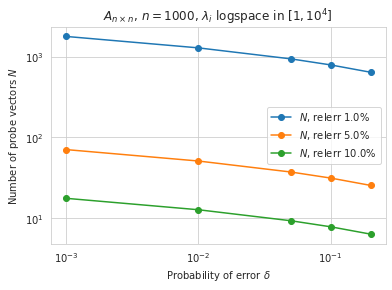

In [33]:
relerrs = (0.01, 0.05, 0.1)
probas = (0.001, 0.01, 0.05, 0.1, 0.2)


for relerr in relerrs:
    bounds = [
        compute_logdet_bounds(eigs, relerr, proba)
        for proba in probas
    ]
    Ns, ms = zip(*bounds)
    plt.plot(probas, Ns, '-o', label=f'$N$, relerr {relerr*100}%')

plt.legend()
plt.yscale('log'); plt.xscale('log')
plt.tick_params(axis='y', which='minor')
plt.xlabel('Probability of error $\delta$')
plt.ylabel('Number of probe vectors $N$')
plt.title(r'$A_{n \times n}, \, n = 1000$, $\lambda_i$ logspace in $[1, 10^4]$');

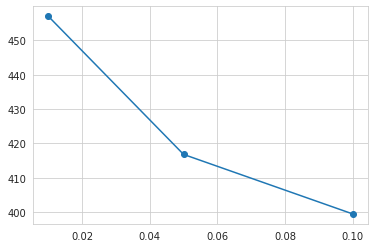

In [68]:
ms = [
    compute_logdet_bounds(eigs, relerr, 0.1)[1]
    for relerr in relerrs
]
plt.plot(relerrs, ms, '-o')

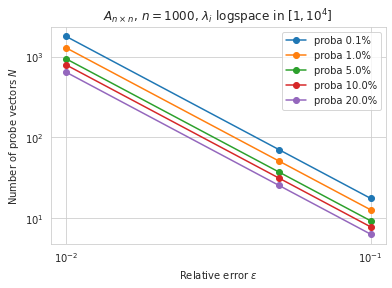

In [25]:
relerrs = (0.01, 0.05, 0.1)
probas = (0.001, 0.01, 0.05, 0.1, 0.2)

for proba in probas:
    bounds = [
        compute_logdet_bounds(eigs, relerr, proba)
        for relerr in relerrs
    ]
    Ns, ms = zip(*bounds)
    plt.plot(relerrs, Ns, '-o', label=f'proba {proba*100}%')

#plt.xscale('log')
plt.legend()
plt.yscale('log'); plt.xscale('log')
plt.tick_params(axis='y', which='minor')
plt.xlabel('Relative error $\epsilon$')
plt.ylabel('Number of probe vectors $N$')
plt.title(r'$A_{n \times n}, \, n = 1000$, $\lambda_i$ logspace in $[1, 10^4]$');

# Logdet of SPD matrix

In [27]:
from src.inference import compute_logdet

## Logdet without preconditionning

We don't use preconditionning here, so the matrix has to be well-conditionned, otherwise the number of Lanczos steps will be too big.

In [52]:
from math import log10

def build_A(n: int, lmin: float, lmax: float, logspace: bool = True, device='cuda'):
    assert lmin > 0
    
    Q = torch.from_numpy(ortho_group.rvs(n)).to(device)
    if logspace:
        eigs = torch.logspace(log10(lmin), log10(lmax), n, device=device)
    else:
        eigs = torch.linspace(lmin, lmax, n, device=device)
    A = Q @ torch.diag(eigs) @ Q.T
    
    return A, eigs

In [82]:
A, eigs = build_A(n=1000, lmin=1, lmax=1e2, logspace=True, device='cpu')

compute_logdet_bounds(eigs, 0.05, 0.05)

(37.41322728914573, 36.49501263710895)

In [84]:
%%time
Ns = (10, 37, 50, 100)
m = 37
reps = 1000

results = []
for N in Ns:
    # The estimates are iid, so compute everything in one shot
    estimates = compute_logdet(A, N*reps, m, return_avg=False)
    # Compute the averages for each independent run
    estimates = estimates.reshape(reps, N).mean(axis=1)
    results.append(estimates)

CPU times: user 11min 48s, sys: 2min 24s, total: 14min 13s
Wall time: 2min 57s


In [101]:
true = eigs.log().sum().item()
rel_errors_perc = np.abs(np.array(results) - true) / true * 100
rel_errors_perc

array([[1.37285149, 1.06600406, 0.58785305, ..., 1.57906322, 1.44397915,
        2.71377201],
       [0.53399371, 0.57004062, 1.62728347, ..., 0.61725416, 0.83215492,
        0.1599653 ],
       [0.41959915, 0.45693282, 0.79778446, ..., 0.0362663 , 0.36864048,
        0.09671768],
       [0.59246946, 0.87126263, 0.2813759 , ..., 1.01137869, 0.13781759,
        0.16449207]])

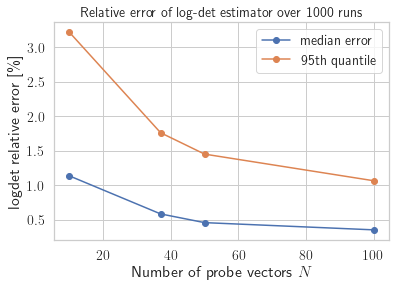

In [119]:
# Mean errors
plt.plot(Ns, np.median(rel_errors_perc, axis=1), '-o', label='median error')
# 95th Quantile
q = np.quantile(rel_errors_perc, 0.95, axis=1)

plt.title(f'Relative error of log-det estimator over {reps} runs')
plt.plot(Ns, q, '-o', label='95th quantile')
plt.ylabel('logdet relative error [\%]')
plt.xlabel('Number of probe vectors $N$')
plt.legend();

## Logdet with preconditionning

In [214]:
from src.inference import inference

In [277]:
n, k = 1000, 100
sigma2 = 1.0

A, eigs = build_A(n=n, lmin=1, lmax=100, logspace=True, device='cpu')
Ahat = A + sigma2 * torch.eye(n)

In [278]:
precond_eigs = compute_precond_eigs(A, k, sigma2)

In [279]:
precond_eigs.max() / precond_eigs.min()

tensor(87.1479)

In [282]:
compute_logdet_bounds(precond_eigs, 0.05, 0.05)

(37.93488325163729, 34.11409077025247)

In [292]:
inference(A, k, sigma2, N=50, m=40)

1016.8034604802733

In [284]:
P.logdet()

388.08751617983717

In [285]:
torch.logdet(A + sigma2 * torch.eye(n))

tensor(2479.1908)

In [129]:
n, k = 100, 30

M = torch.randn(n, n)
A = M @ M.T
Ahat = A + torch.eye(n) 
P = PartialCholesky(A, k, 1.0)

In [131]:
Pkhat = P.Pk_hat()

precond_mx = P.inv_fun(Ahat)
torch.logdet(precond_mx)

tensor(226.6356)

In [136]:
torch.logdet(Ahat) - P.logdet()

tensor(226.6356)

## Check sampling

In [183]:
n = 10
M = torch.randn(n, n)
S = M @ M.T

In [186]:
P = PartialCholesky(S, k=3, sigma2=1)

In [190]:
errs=[]
for N in Ns:
    Y = P.sample_gaussian(size=N)
    Ycov = torch.cov(Y)
    errs.append(torch.frobenius_norm(P.Pk_hat() - Ycov))

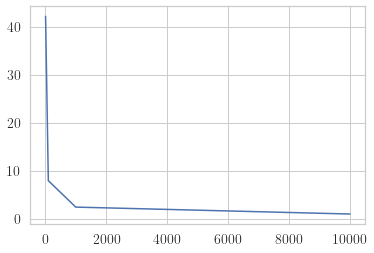

In [192]:
plt.plot(Ns, errs)

In [180]:
Ns = (10, 100, 1000, 10000)
errs = []
for N in Ns:
    X = torch.randn(n, N)
    Y = (M + torch.randn_like(M) * 0.5) @ X
    err = torch.frobenius_norm(S - torch.cov(Y))
    errs.append(err)

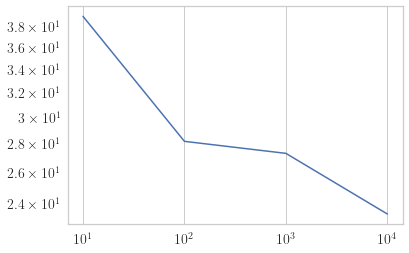

In [181]:
plt.loglog(Ns, errs)

In [162]:
N = 10000
X = torch.randn(n, N)
Y = M @ X

In [163]:
Semp = torch.cov(Y)

In [165]:
torch.frobenius_norm(Semp - S)

tensor(0.9195)

In [152]:
(S - Semp).abs().max()

tensor(2.4258)

In [139]:
Y.shape

torch.Size([10, 100])

# Check mbcg

In [476]:
n = 100
Q = torch.from_numpy(ortho_group.rvs(n))
eigs = torch.linspace(1, 1000, n)
A = Q @ torch.diag(eigs) @ Q.T
Ainv = Q @ torch.diag(1/eigs) @ Q.T

b = torch.randn(n)
x = torch.linalg.solve(A, b)
(x - Ainv@b).norm()

k = 100
xk, _ = mbcg(lambda X: A@X, lambda X: X, b, torch.zeros_like(b), k)
(x - xk).norm() / x.norm()

tensor(8.3693e-15)

In [477]:
n = 100
M = torch.randn(n, n)
A = M @ M.T + torch.eye(n)

b = torch.randn(n)
x = torch.linalg.solve(A, b)

k = 100
xk, _ = mbcg(lambda X: A@X, lambda X: X, b, torch.zeros_like(b), k)

err = (x - xk).norm() / x.norm()
err

tensor(2.1525e-06)

In [479]:
e = torch.linalg.eigvalsh(A)
e.min(), e.max()

(tensor(1.0072), tensor(352.0566))